In [1]:
import sys
import os

import numpy as np
import keras

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import Bidirectional, TimeDistributed, GRU
from keras.layers import LSTM, Input, Reshape, Concatenate, Flatten,Convolution1D
from keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPool2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

import itertools
import pandas as pd

import spacy
import nltk
import re

from tqdm import tqdm
from os.path import expanduser, exists

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam

from nltk import tokenize
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical


%matplotlib inline
sns.set(style='whitegrid', palette='muted')
pd.set_option('display.max_colwidth', 300) #widen pandas rows display

Using TensorFlow backend.


In [3]:
def to_label(cat):
    return categories[cat]

# data_train = pd.read_csv('data/fake.csv')

##### FakeNewsNet #####################################
# def add_text(row):
#     return row['title_tokens'] + ' ' + row['text_tokens'] 
    
# categories = {'FakeNewsContent':'False', 'RealNewsContent':'True'}
# data_train = pd.read_csv('data/fakeNewsNet.csv', sep='\t')
# data_train.dropna(how='any', inplace=True) 
# print(data_train['collected_by'].unique())
# print(data_train['collected_by'].value_counts())
# print(data_train['label'].unique())
# print(data_train.isnull().values.any())
# data_train['label'] = data_train['label'].apply(to_label)
# data_train['document'] = data_train.apply(add_text, axis=1)
# X =  data_train['document'].values
# y = data_train['label'].values
# labels = data_train['label'].unique()
# print(data_train['label'].value_counts())
# labels = data_train['label'].unique()
# print(labels)
# num_classes = len(labels)
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
#################################################


##### Fact Checking
# data_train = pd.read_csv('data/newsfiles/fulltrain.csv', names=['label', 'text'])
# categories = {1:"Satire",2:"Hoax",
#               3:"Propaganda",4:"Trusted"}

#### PolitiFact
# data_train = pd.read_csv('/home/paperspace/sonic/fakeNews/data/politifact.tsv', sep='\t')
# def label(row):
# #     print(row)
#     if row in ['true', 'half-true', 'mostly-true']:
#         return 'true'
#     else:
#         return 'false'

# data_train['label'] = data_train['ruling'].apply(label)
##########
    
##### Unreliable News Data ##################################
data_train = pd.read_csv('data/newsfiles/fulltrain.csv', names=['label', 'text'])
categories = {1:"Satire",2:"Hoax",
              3:"Propaganda",4:"Trusted"}

data_train['label'] = data_train['label'].apply(to_label)
X =  data_train['text'].values
y = data_train['label'].values
labels = data_train['label'].unique()
num_classes = len(labels)
print(data_train['label'].value_counts())
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
############################



    
# data_train['label'] = data_train['label'].apply(to_label)

#####
# categories = {0:'true', 1: 'false'}
# data_train = pd.read_csv('data/RumerTwitter.csv', sep='\t')
# data_train['label'] = data_train['label'].apply(to_label)
#####

##### SNOPES
# data_train = pd.read_csv('data/snopes_processed.tsv', sep='\t')
# # data_train['label'] = data_train['label'].apply(str)
# # data_train['label'] = data_train['label'].astype(str)
# categories = {True:u'true', False: u'false'}
# data_train['label'] = data_train['label'].apply(to_label)

data_train.tail()
# data_train.info()

Propaganda    17870
Satire        14047
Trusted        9995
Hoax           6942
Name: label, dtype: int64


,label,text
48849,Trusted,"The ruling Kuomintang (KMT) has claimed ownership of a slush fund of NT$240 million (US$7.65 million) two days after the frozen money was collected from the court by James Soong, chairman of the now-marginalized People First Party. KMT spokesman Su Jun-pin told a news conference Thursday that th..."
48850,Trusted,"The Taipei city government has encouraged the rebuilding of low-to-mid-rise residential buildings in the city that are 30 years or more old through financial and technical assistance programs. The move, however, has drawn questions and criticism from the Ministry of the Interior and lawmakers. T..."
48851,Trusted,"President Ma Ying-jeou said Friday that a park being built to commemorate Japanese civil engineer Yoichi Hatta, whose work contributed greatly to the success of an irrigation system in southern Taiwan, is slated to be inaugurated May 8 next year. The Yoichi Hatta Memorial Park, located at Wushan..."
48852,Trusted,"The families of the four people who were killed in a landslide on National Freeway No. 3 last Sunday are entitled to national compensation. No one could take issue with this. But as taxpayers, we are entitled to know whether any government officials were responsible for the disaster; if there we..."
48853,Trusted,"The Ministry of Finance will make public on Saturday names of big tax defaulters that owe the government a total of NT$130.8 billion (US$4.15 billion) in taxes, a ministry official said Friday. The list of 1,558 defaulters will consist of individuals who owe at least NT$10 million in unpaid tax ..."


# Emedding

In [5]:
MAX_SENT_LENGTH = 300
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


max_words = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100 


def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


reviews = []
# labels = []
texts = []


# Specify which key to use from DataFrame
# text_key = 'document' # FakeNewsNet
text_key = 'text'
# text_key = 'statement__text'
# text_key = 'thread_title'
# text_key = 'tokens'
label = 'label'
# label = 'type'


for text in tqdm(data_train[text_key].values):
#     text = BeautifulSoup(data_train.review[idx])
    text = clean_str(str(text))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1 
                    
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

num_classes = len(data_train[label].unique())
print(num_classes, 'classes')

y = pd.get_dummies(data_train[label]).values
labels = data_train['label'].unique()
print(type(labels))

# labels = to_categorical(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


100%|██████████| 48854/48854 [00:49<00:00, 979.96it/s] 


Total 233714 unique tokens.
4 classes
<class 'numpy.ndarray'>
Shape of data tensor: (48854, 15, 300)
Shape of label tensor: (4,)


In [6]:
X = data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (39083, 15, 300)
x_test shape: (9771, 15, 300)
y_train shape: (39083, 4)
y_test shape: (9771, 4)


In [7]:
embeddings_index = {}
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_FILE = 'glove.6B.100d.txt'

print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))


Processing glove.6B.100d.txt
Word embeddings: 400000


In [8]:

def get_embedding_layer():
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SENT_LENGTH,
                                trainable=True)
    return embedding_layer

In [11]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(model, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    y_pred = model.predict(x_test)
    class_labels = np.argmax(y_test, axis=1) 
    print(metrics.classification_report(class_labels, y_pred.argmax(axis=1), 
                                        target_names=data_train['label'].unique(), digits=3))
        
    #Plot ROC curve
#     plot_ROC(class_labels, y_pred)
    
    cm = confusion_matrix(class_labels, 
                          y_pred.argmax(axis=1))
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_ROC(class_labels, y_pred):
        
    print("Accuracy = {0} \t AUC = {1}".format(accuracy_score(class_labels, y_pred.argmax(axis=1)),
                                           roc_auc_score(class_labels, y_pred[:, 1])))

    fpr, tpr, _ = roc_curve(class_labels, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
#     print(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))



model fitting - Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 300)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           23532300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 23,773,904
Trainable params: 23,773,904
Non-trainable params: 0
_________________________________________________________________
None
Train on 39083 samples, validate on 9771 samples
Epoch 1/20
39083/39083 [==============================] - 325s 8ms/step - loss: 0.4577 - acc: 0.8282 - val_loss: 0.2370 - val_acc: 0.9134

Epoch 00001: val_acc improved from -

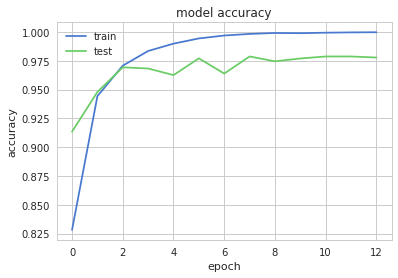

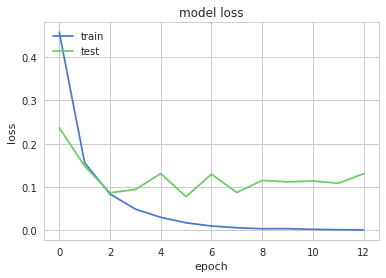

             precision    recall  f1-score   support

     Satire      0.993     0.972     0.982      1371
       Hoax      0.985     0.983     0.984      3587
 Propaganda      0.970     0.986     0.978      2793
    Trusted      0.965     0.960     0.963      2020

avg / total      0.978     0.978     0.978      9771



ValueError: multiclass format is not supported

In [10]:
# RUN THE HIERACHICAL LSTM MODEL
batch_size = 128
epochs = 20

##########
filepath="data/weights_base.BiLSTM_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
# ra_val = RocAucEvaluation(validation_data=(x_test, y_test), interval = 1)
callbacks_list = [checkpoint, 
#                   ra_val,
                  early]
##########


sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = get_embedding_layer()(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(num_classes, activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Hierachical LSTM")
print(model.summary())


network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         callbacks = callbacks_list,
                         validation_split=0.2)

score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

x_train (39083, 15, 300) y_train (39083, 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15, 300)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200)           23512300  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 15, 200)           180600    
_________________________________________________________________
att_layer_2 (AttLayer)       (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 804       
Total params: 23,713,904
Trainable params: 23,713,904
Non-trainable params: 0
_________________________________________________________________
None
model fitting - Hierachical attention network
Train on 39083 samples, validate o

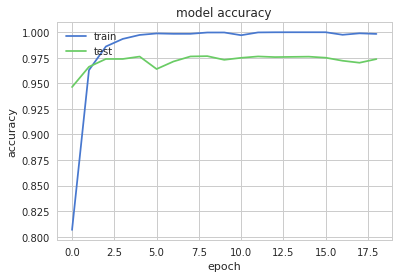

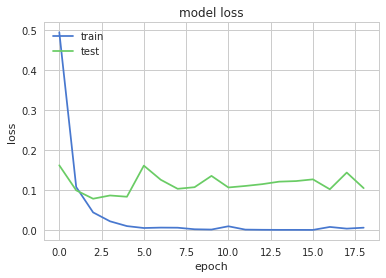

             precision    recall  f1-score   support

     Satire      0.972     0.980     0.976      1371
       Hoax      0.983     0.977     0.980      3587
 Propaganda      0.969     0.985     0.977      2793
    Trusted      0.966     0.948     0.957      2020

avg / total      0.974     0.974     0.974      9771

Confusion matrix, without normalization
[[1343   10    9    9]
 [  23 3506   21   37]
 [  10   12 2750   21]
 [   6   40   59 1915]]


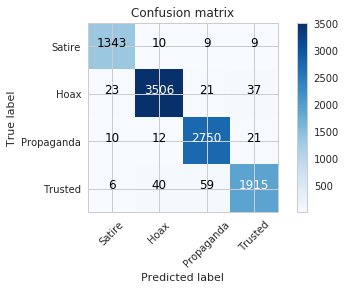

In [12]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

##########
filepath="data/weights_base_HAN.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=10)
ra_val = RocAucEvaluation(validation_data=(x_test, y_test), interval = 1)
callbacks_list = [checkpoint, 
#                   ra_val,
                  early]
##########

batch_size = 128
epochs = 20

GPU_IMPL = 2          
GRU_UNITS = 100    
MAX_SENTS = 15

# building Hierachical Attention network

REG_PARAM = 1e-10
l2_reg = regularizers.l2(REG_PARAM)
CONTEXT_DIM = EMBEDDING_DIM

import sys
import os

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttLayer(Layer):
    def __init__(self, regularizer=None, **kwargs):
        self.regularizer = regularizer
        self.supports_masking = True
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3        
        self.W = self.add_weight(name='W', shape=(input_shape[-1], CONTEXT_DIM),
                                 initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(CONTEXT_DIM,), 
                                 initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(CONTEXT_DIM,), 
                                 initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)        
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = dot_product(K.tanh(K.dot(x, self.W) + self.b), self.u)
        ai = K.exp(eij)
        alphas = ai / K.expand_dims(K.sum(ai, axis=1),1)
        if mask is not None:
            # use only the inputs specified by the mask
            alphas *= mask
        weighted_input = x * K.expand_dims(alphas, 2)

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None
    

def get_HAT():
    sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#     embedded_sequences = get_embedding_layer()(sentence_input)
    embedded_sequences = get_embedding_layer()(sentence_input)
    l_lstm = Bidirectional(GRU(GRU_UNITS, return_sequences=True, kernel_regularizer=l2_reg, 
                               implementation=GPU_IMPL))(embedded_sequences)
    l_att = AttLayer(regularizer=l2_reg)(l_lstm)            
    sentEncoder = Model(sentence_input, l_att)

    review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
    review_encoder = TimeDistributed(sentEncoder)(review_input)
    l_lstm_sent = Bidirectional(GRU(GRU_UNITS, return_sequences=True, kernel_regularizer=l2_reg, 
                                    implementation=GPU_IMPL))(review_encoder)
    l_att_sent = AttLayer(regularizer=l2_reg)(l_lstm_sent)       
    preds = Dense(num_classes, activation='softmax', kernel_regularizer=l2_reg)(l_att_sent)
    model = Model(review_input, preds)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=1e-3), 
                  metrics=['acc'])
    return model

print('x_train', x_train.shape, 'y_train', y_train.shape)
print()

model = get_HAT()
print(model.summary())


print("model fitting - Hierachical attention network")
# model.fit(x_train, y_train, validation_data=(x_test, y_test),
#           epochs=10, batch_size=50)

network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         callbacks = callbacks_list,
                         validation_split=0.2)

score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')